# MNIST - Data Generator

This code generates synthetic MNIST data through elastic transforms and uses a series of filtering steps to reduce the difficulty of the training data.

In [21]:
from __future__ import absolute_import, division, print_function
import os, sys, pdb, pickle
from itertools import product
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Lambda, Activation, Add
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.engine.topology import Layer
from keras import regularizers, activations
from keras import backend as K

os.environ['CUDA_VISIBLE_DEVICES']=''

## Define the elastic transform methods.

We are using code from [mnist_helpers](https://github.com/vsvinayak/mnist-helper/blob/master/mnist_helpers.py) to generate elastic transforms.

In [22]:
# Elastic Transforms: https://github.com/vsvinayak/mnist-helper/blob/master/mnist_helpers.py
# Other stuff on elastic transforms (not used here):
#   - https://evizero.github.io/Augmentor.jl/generated/mnist_elastic/
#   - https://www.microsoft.com/en-us/research/wp-content/uploads/2003/08/icdar03.pdf

import cv2
from scipy.signal import convolve2d

def create_2d_gaussian(dim, sigma):
    """
    This function creates a 2d gaussian kernel with the standard deviation
    denoted by sigma
    
    :param dim: integer denoting a side (1-d) of gaussian kernel
    :type dim: int
    :param sigma: the standard deviation of the gaussian kernel
    :type sigma: float
    
    :returns: a numpy 2d array
    """

    # check if the dimension is odd
    if dim % 2 == 0:
        raise ValueError("Kernel dimension should be odd")

    # initialize the kernel
    kernel = np.zeros((dim, dim), dtype=np.float16)

    # calculate the center point
    center = dim/2

    # calculate the variance
    variance = sigma ** 2
    
    # calculate the normalization coefficeint
    coeff = 1. / (2 * variance)

    # create the kernel
    for x in range(0, dim):
        for y in range(0, dim):
            x_val = abs(x - center)
            y_val = abs(y - center)
            numerator = x_val**2 + y_val**2
            denom = 2*variance
            
            kernel[x,y] = coeff * np.exp(-1. * numerator/denom)
    
    # normalise it
    return kernel/sum(sum(kernel))

def elastic_transform(image, kernel_dim=13, sigma=6, alpha=36, negated=False):
    """
    This method performs elastic transformations on an image by convolving 
    with a gaussian kernel.
    NOTE: Image dimensions should be a sqaure image
    
    :param image: the input image
    :type image: a numpy nd array
    :param kernel_dim: dimension(1-D) of the gaussian kernel
    :type kernel_dim: int
    :param sigma: standard deviation of the kernel
    :type sigma: float
    :param alpha: a multiplicative factor for image after convolution
    :type alpha: float
    :param negated: a flag indicating whether the image is negated or not
    :type negated: boolean
    :returns: a nd array transformed image
    """
    
    # convert the image to single channel if it is multi channel one
    if image.ndim == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # check if the image is a negated one
    if not negated:
        image = 255-image

    # check if the image is a square one
    if image.shape[0] != image.shape[1]:
        raise ValueError("Image should be of sqaure form")

    # check if kernel dimesnion is odd
    if kernel_dim % 2 == 0:
        raise ValueError("Kernel dimension should be odd")

    # create an empty image
    result = np.zeros(image.shape)

    # create random displacement fields
    displacement_field_x = np.array([[np.random.randint(-1, 2) for x in xrange(image.shape[0])] \
                            for y in xrange(image.shape[1])]) * alpha
    displacement_field_y = np.array([[np.random.randint(-1, 2) for x in xrange(image.shape[0])] \
                            for y in xrange(image.shape[1])]) * alpha

    # create the gaussian kernel
    kernel = create_2d_gaussian(kernel_dim, sigma)

    # convolve the fields with the gaussian kernel
    displacement_field_x = convolve2d(displacement_field_x, kernel)
    displacement_field_y = convolve2d(displacement_field_y, kernel)

    # make the distortrd image by averaging each pixel value to the neighbouring
    # four pixels based on displacement fields
    
    for row in xrange(image.shape[1]):
        for col in xrange(image.shape[0]):
            low_ii = row + int(np.floor(displacement_field_x[row, col]))
            high_ii = row + int(np.ceil(displacement_field_x[row, col]))

            low_jj = col + int(np.floor(displacement_field_y[row, col]))
            high_jj = col + int(np.ceil(displacement_field_y[row, col]))

            if low_ii < 0 or low_jj < 0 or high_ii >= image.shape[1] -1 \
               or high_jj >= image.shape[0] - 1:
                continue

            res = image[low_ii, low_jj]/4 + image[low_ii, high_jj]/4 + \
                    image[high_ii, low_jj]/4 + image[high_ii, high_jj]/4

            result[row, col] = res
    
    # if the input image was not negated, make the output image also a non 
    # negated one
    if not negated:
        result = 255-result

    return result

## Load the MNIST data and view the effects of elastic transforms

In [23]:
num_classes = 10

# Grab and massage the training and test data.
(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_rows, img_cols = x_train.shape[1:3]

x_train = x_train.astype('float32') / 255
x_test  = x_test.astype('float32') / 255
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test  = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

np.random.seed(0)
val_set = np.zeros(x_train.shape[0], dtype='bool')
val_set[np.random.choice(x_train.shape[0], 10000, replace=False)] = 1
x_val = x_train[val_set]
y_val = y_train[val_set]
x_train = x_train[~val_set]
y_train = y_train[~val_set]

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'val samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 28, 28, 1)
50000 train samples
10000 val samples
10000 test samples


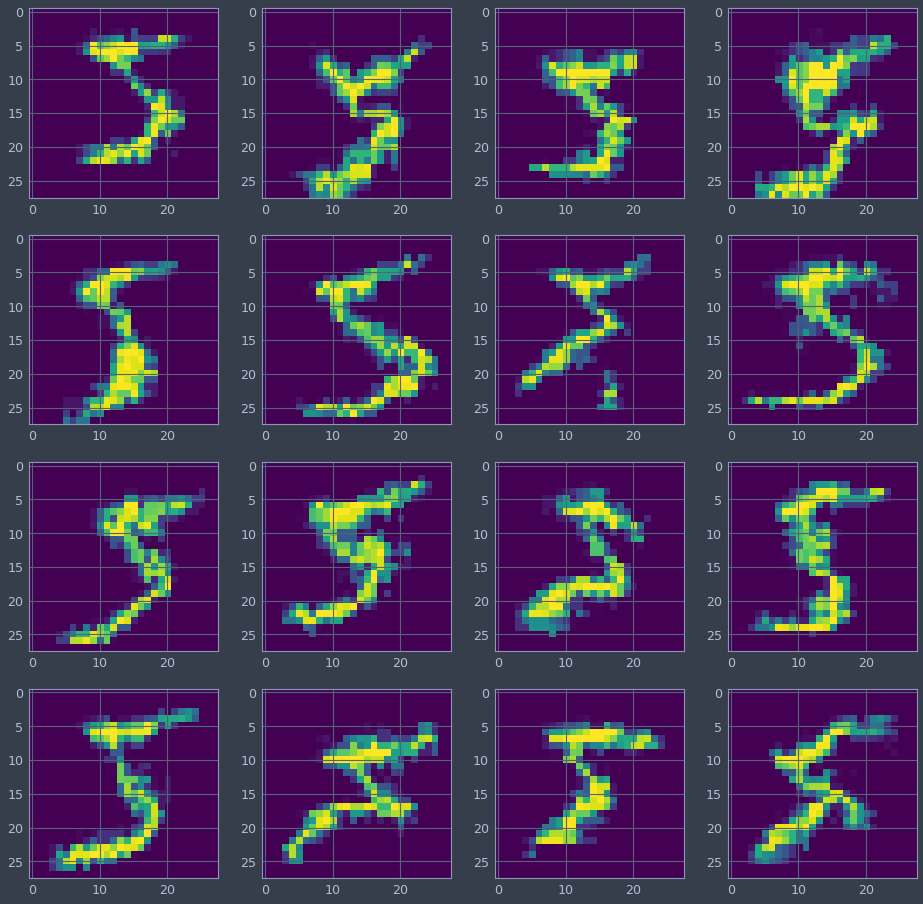

In [24]:
et_i = 0
et_k = 13
et_s = 6
et_a = 36
plt.figure(figsize=(16,16))
for i in range(4):
    for j in range(4):
        plt.subplot(4,4,4*i+j+1)
        plt.imshow(elastic_transform(np.squeeze(x_train[et_i]), kernel_dim=et_k, sigma=et_s, alpha=et_a, negated=True))
plt.show()

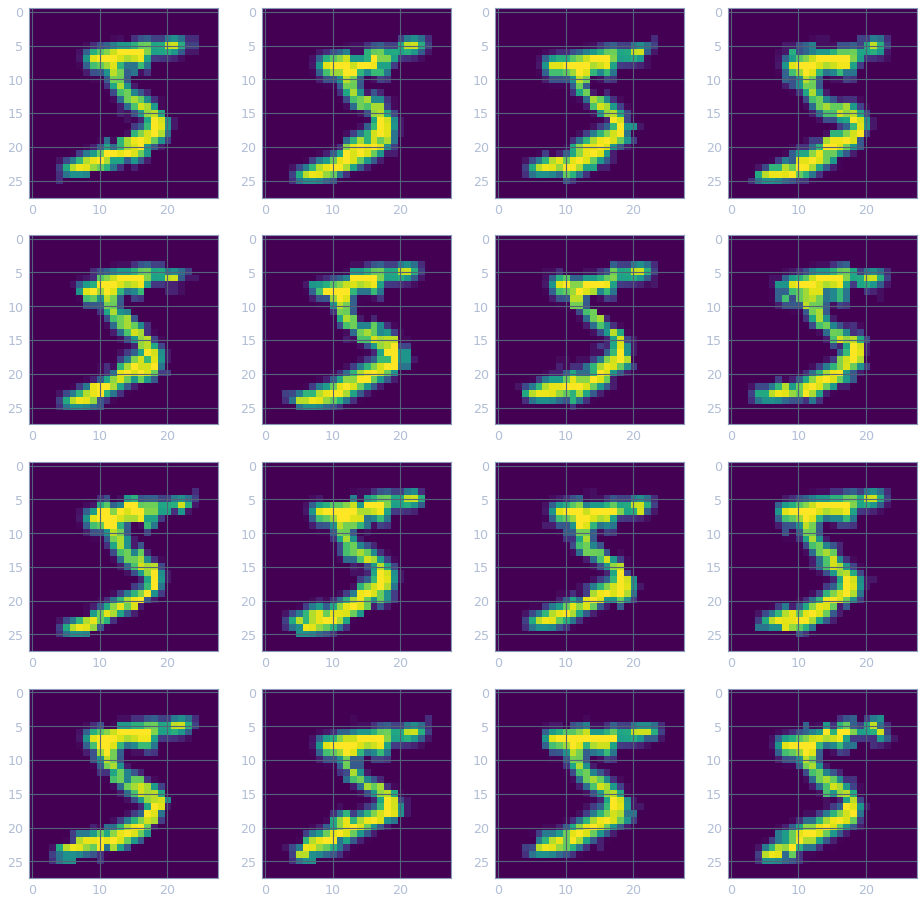

In [4]:
et_i = 0
et_k = 9
et_s = 4
et_a = 5
plt.figure(figsize=(16,16))
for i in range(4):
    for j in range(4):
        plt.subplot(4,4,4*i+j+1)
        plt.imshow(elastic_transform(np.squeeze(x_train[et_i]), kernel_dim=et_k, sigma=et_s, alpha=et_a, negated=True))
plt.show()

## Generate augmented data with "minor" elastic transforms

In [8]:
augx = 4
x_train_aug = []
y_train_aug = []
for i in range(x_train.shape[0]):
    print('\rOn %d/%d'%(i+1, x_train.shape[0]), end='')
    y_train_aug += [y_train[i]] * augx
    x_train_aug.append(x_train[i])
    x = np.squeeze(x_train[i])
    for j in range(augx-1):
        x_train_aug.append(np.expand_dims(elastic_transform(x, kernel_dim=9, sigma=4, alpha=5, negated=True), -1))
x_train_aug = np.array(x_train_aug)
y_train_aug = np.array(y_train_aug)
print('\nDone.')

On 50000/50000
Done.


In [9]:
with open('augmented_x_200k.npy', 'wb') as f:
    np.save(f, x_train_aug)
with open('augmented_y_200k.npy', 'wb') as f:
    np.save(f, y_train_aug)

In [2]:
with open('augmented_x_200k.npy', 'rb') as f:
    x_train_aug = np.load(f)
with open('augmented_y_200k.npy', 'rb') as f:
    y_train_aug = np.load(f)

## Generate augmented data with "major" elastic transforms

In [39]:
augx = 1
x_train_augh = []
y_train_augh = []
for i in range(x_train.shape[0]):
    print('\rOn %d/%d'%(i+1, x_train.shape[0]), end='')
    y_train_augh += [y_train[i]] * augx
    x = np.squeeze(x_train[i])
    for j in range(augx):
        x_train_augh.append(np.expand_dims(elastic_transform(x, kernel_dim=13, sigma=6, alpha=20, negated=True), -1))
x_train_augh = np.array(x_train_augh)
y_train_augh = np.array(y_train_augh)
print('\nDone.')

On 50000/50000
Done.


In [40]:
with open('augmented_x_50kh.npy', 'wb') as f:
    np.save(f, x_train_augh)
with open('augmented_y_50kh.npy', 'wb') as f:
    np.save(f, y_train_augh)

In [3]:
with open('augmented_x_50kh.npy', 'rb') as f:
    x_train_augh = np.load(f)
with open('augmented_y_50kh.npy', 'rb') as f:
    y_train_augh = np.load(f)

## Remove "bad" augmented data from the minor-elastic-deformation dataset

First, train a powerful CNN on the original MNIST dataset. Use that model to predict the classes of the augmented dataset and throw out any data that is not correctly predicted.

In [6]:
num_classes = 10

# Grab and massage the training and test data.
(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_rows, img_cols = x_train.shape[1:3]

x_train = x_train.astype('float32') / 255
x_test  = x_test.astype('float32') / 255
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test  = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

np.random.seed(0)
val_set = np.zeros(x_train.shape[0], dtype='bool')
val_set[np.random.choice(x_train.shape[0], 10000, replace=False)] = 1
x_val = x_train[val_set]
y_val = y_train[val_set]
x_train = x_train[~val_set]
y_train = y_train[~val_set]

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'val samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 28, 28, 1)
50000 train samples
10000 val samples
10000 test samples


In [26]:
batch_size = 1024

lrate95 = LearningRateScheduler(lambda epoch: max(1e-4, 0.005 * 0.95**epoch))
ckptF = ModelCheckpoint('modelDAF.h5', monitor='val_loss', verbose=0, save_best_only=True)

def output_logits_orig(X):
    # https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6
    X = Conv2D(32, (5,5), padding='same', activation='relu')(X)
    X = Conv2D(32, (5,5), padding='same', activation='relu')(X)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)
    X = Conv2D(64, (3,3), padding='same', activation='relu')(X)
    X = Conv2D(64, (3,3), padding='same', activation='relu')(X)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)
    X = Flatten()(X)
    X = Dense(256, activation='relu')(X)
    X = Dropout(0.5)(X)
    X = Dense(10, activation=None)(X)
    return X

def output_logits_res(X):
    Xr = X
    X = Conv2D(64, (5,5), padding='same', activation='relu')(X)
    X = Conv2D(64, (5,5), padding='same', activation=None)(X)
    X = Add()([X, Xr])
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)
    Xr = X
    X = Conv2D(64, (3,3), padding='same', activation='relu')(X)
    X = Conv2D(64, (3,3), padding='same', activation=None)(X)
    X = Add()([X, Xr])
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)
    X = Flatten()(X)
    X = Dense(256, activation='relu')(X)
    X = Dropout(0.5)(X)
    X = Dense(10, activation=None)(X)
    return X


def output_logits(X):
    X = Conv2D(32, (5,5), padding='same', activation='relu')(X)
    X = Conv2D(32, (5,5), padding='same', activation='relu')(X)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)
    
    X = Conv2D(32, (3,3), padding='same', activation='relu')(X)
    X = Conv2D(32, (3,3), padding='same', activation='relu')(X)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)
    X = Flatten()(X)
    
    X = Dense(256, activation='relu')(X)
    X = Dropout(0.5)(X)
    X = Dense(10, activation=None)(X)
    return X
    
X_input = Input(shape=x_train.shape[1:])
X = output_logits(X_input)
X = Activation('softmax')(X)
modelF = Model(X_input, X)
modelF.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
histf = modelF.fit(x_train, y_train, batch_size=batch_size, epochs=30, callbacks=[lrate95, ckptF], verbose=1, validation_data=(x_val, y_val))
modelF = load_model('modelDAF.h5')

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 5s 99us/step - loss: 0.6197 - acc: 0.8006 - val_loss: 0.0763 - val_acc: 0.9761
Epoch 2/30
50000/50000 [==============================] - 2s 48us/step - loss: 0.1030 - acc: 0.9679 - val_loss: 0.0427 - val_acc: 0.9872
Epoch 3/30
50000/50000 [==============================] - 2s 48us/step - loss: 0.0732 - acc: 0.9782 - val_loss: 0.0330 - val_acc: 0.9903
Epoch 4/30
50000/50000 [==============================] - 2s 48us/step - loss: 0.0599 - acc: 0.9820 - val_loss: 0.0326 - val_acc: 0.9893
Epoch 5/30
50000/50000 [==============================] - 2s 47us/step - loss: 0.0493 - acc: 0.9847 - val_loss: 0.0269 - val_acc: 0.9911
Epoch 6/30
50000/50000 [==============================] - 2s 49us/step - loss: 0.0446 - acc: 0.9864 - val_loss: 0.0265 - val_acc: 0.9917
Epoch 7/30
50000/50000 [==============================] - 2s 47us/step - loss: 0.0373 - acc: 0.9885 - val_loss: 0.0244 - val_acc

In [4]:
modelF = load_model('modelDAF.h5')
yp = modelF.predict(x_train_aug)
match = (np.argmax(yp, -1) == np.argmax(y_train_aug, -1))

In [34]:
x_train_aug_filt = x_train_aug[match]
y_train_aug_filt = y_train_aug[match]

## Remove "bad" augmented data from the "major-elastic-deformation" dataset

Use the filtered version of the minor-elastic-deformation dataset as training data and train the powerful CNN model on it. Then, use the updated model to throw out bad data from the major-elastic-deformation dataset, similar to what was done for the minior-elastic-deformation dataset.

In [35]:
lrate95 = LearningRateScheduler(lambda epoch: max(1e-4, 0.005 * 0.95**epoch))
ckptF = ModelCheckpoint('modelDAbF.h5', monitor='val_loss', verbose=0, save_best_only=True)

X_input = Input(shape=x_train.shape[1:])
X = output_logits(X_input)
X = Activation('softmax')(X)
modelF = Model(X_input, X)
modelF.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
histf = modelF.fit(x_train_aug_filt, y_train_aug_filt, batch_size=batch_size, epochs=30, callbacks=[lrate95, ckptF], verbose=1, validation_data=(x_val, y_val))
modelF = load_model('modelDAbF.h5')

Train on 198921 samples, validate on 10000 samples
Epoch 1/30
198921/198921 [==============================] - 12s 61us/step - loss: 0.1964 - acc: 0.9353 - val_loss: 0.0399 - val_acc: 0.9879
Epoch 2/30
198921/198921 [==============================] - 9s 47us/step - loss: 0.0533 - acc: 0.9832 - val_loss: 0.0321 - val_acc: 0.9910
Epoch 3/30
198921/198921 [==============================] - 9s 47us/step - loss: 0.0405 - acc: 0.9872 - val_loss: 0.0237 - val_acc: 0.9924
Epoch 4/30
198921/198921 [==============================] - 9s 47us/step - loss: 0.0330 - acc: 0.9898 - val_loss: 0.0257 - val_acc: 0.9929
Epoch 5/30
198921/198921 [==============================] - 9s 47us/step - loss: 0.0280 - acc: 0.9911 - val_loss: 0.0272 - val_acc: 0.9929
Epoch 6/30
198921/198921 [==============================] - 9s 47us/step - loss: 0.0244 - acc: 0.9921 - val_loss: 0.0216 - val_acc: 0.9939
Epoch 7/30
198921/198921 [==============================] - 9s 47us/step - loss: 0.0229 - acc: 0.9925 - val_loss: 

In [5]:
modelF = load_model('modelDAbF.h5')
yph = modelF.predict(x_train_augh)
matchh = (np.argmax(yph, -1) == np.argmax(y_train_augh, -1))

## Combine augmented datasets and save

After combining the datasets, try training a fresh network on this dataset and see how validation accuracy improves.

In [53]:
x_train_full = np.concatenate([x_train_aug[match], x_train_augh[matchh]], axis=0)
y_train_full = np.concatenate([y_train_aug[match], y_train_augh[matchh]], axis=0)

np.random.seed(0)
rsel = np.random.choice(range(x_train_full.shape[0]), 200000, replace=False)

In [54]:
with open('augmented_x_200k_v2.npy', 'wb') as f:
    np.save(f, x_train_full[rsel])
with open('augmented_y_200k_v2.npy', 'wb') as f:
    np.save(f, y_train_full[rsel])

In [55]:
with open('augmented_x_200k_v2.npy', 'rb') as f:
    x_train_full = np.load(f)
with open('augmented_y_200k_v2.npy', 'rb') as f:
    y_train_full = np.load(f)

In [59]:
lrate95 = LearningRateScheduler(lambda epoch: max(1e-4, 0.005 * 0.95**epoch))
ckptF = ModelCheckpoint('modelDAcF.h5', monitor='val_loss', verbose=0, save_best_only=True)

X_input = Input(shape=x_train.shape[1:])
X = output_logits(X_input)
X = Activation('softmax')(X)
modelF = Model(X_input, X)
modelF.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
histf = modelF.fit(x_train_full, y_train_full, batch_size=batch_size, epochs=30, callbacks=[lrate95, ckptF], verbose=1, validation_data=(x_val, y_val))
modelF = load_model('modelDAcF.h5')

Train on 200000 samples, validate on 10000 samples
Epoch 1/30
200000/200000 [==============================] - 12s 61us/step - loss: 0.2343 - acc: 0.9239 - val_loss: 0.0373 - val_acc: 0.9892
Epoch 2/30
200000/200000 [==============================] - 9s 47us/step - loss: 0.0621 - acc: 0.9802 - val_loss: 0.0287 - val_acc: 0.9913
Epoch 3/30
200000/200000 [==============================] - 9s 45us/step - loss: 0.0453 - acc: 0.9856 - val_loss: 0.0250 - val_acc: 0.9936
Epoch 4/30
200000/200000 [==============================] - 9s 45us/step - loss: 0.0378 - acc: 0.9880 - val_loss: 0.0280 - val_acc: 0.9942
Epoch 5/30
200000/200000 [==============================] - 9s 45us/step - loss: 0.0343 - acc: 0.9889 - val_loss: 0.0257 - val_acc: 0.9943
Epoch 6/30
200000/200000 [==============================] - 9s 44us/step - loss: 0.0318 - acc: 0.9897 - val_loss: 0.0332 - val_acc: 0.9927
Epoch 7/30
200000/200000 [==============================] - 9s 44us/step - loss: 0.0278 - acc: 0.9910 - val_loss: 

## Reduce the number of "hard" examples and instead just use them to fill to 200k samples

Randomly select examples from the major-deformations dataset to add to the minor-deformations dataset in order to have exactly 200k training examples. Check the final performance of the CNN on this dataset.

We did not end up using this dataset.

In [12]:
np.random.seed(0)
rsel = np.random.choice(range(x_train_augh.shape[0]), 200000 - x_train_aug.shape[0], replace=False)

x_train_full = np.concatenate([x_train_aug, x_train_augh[rsel]])
y_train_full = np.concatenate([y_train_aug, y_train_augh[rsel]])

idx = range(200000)
np.random.seed(0)
np.random.shuffle(idx)

x_train_full = x_train_full[idx]
y_train_full = y_train_full[idx]

In [16]:
with open('augmented_x_200k_v3.npy', 'wb') as f:
    np.save(f, x_train_full)
with open('augmented_y_200k_v3.npy', 'wb') as f:
    np.save(f, y_train_full)

In [55]:
with open('augmented_x_200k_v3.npy', 'rb') as f:
    x_train_full = np.load(f)
with open('augmented_y_200k_v3.npy', 'rb') as f:
    y_train_full = np.load(f)

In [20]:
batch_size = 1024
lrate95 = LearningRateScheduler(lambda epoch: max(1e-4, 0.005 * 0.95**epoch))
ckptF = ModelCheckpoint('modelDAdF.h5', monitor='val_loss', verbose=0, save_best_only=True)

def output_logits(X):
    X = Conv2D(32, (5,5), padding='same', activation='relu')(X)
    X = Conv2D(32, (5,5), padding='same', activation='relu')(X)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)
    
    X = Conv2D(32, (3,3), padding='same', activation='relu')(X)
    X = Conv2D(32, (3,3), padding='same', activation='relu')(X)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)
    X = Flatten()(X)
    
    X = Dense(256, activation='relu')(X)
    X = Dropout(0.5)(X)
    X = Dense(10, activation=None)(X)
    return X

X_input = Input(shape=x_train.shape[1:])
X = output_logits(X_input)
X = Activation('softmax')(X)
modelF = Model(X_input, X)
modelF.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
histf = modelF.fit(x_train_full, y_train_full, batch_size=batch_size, epochs=30, callbacks=[lrate95, ckptF], verbose=1, validation_data=(x_val, y_val))
modelF = load_model('modelDAdF.h5')

Train on 200000 samples, validate on 10000 samples
Epoch 1/30
200000/200000 [==============================] - 459s 2ms/step - loss: 0.2073 - acc: 0.9327 - val_loss: 0.0382 - val_acc: 0.9893
Epoch 2/30
200000/200000 [==============================] - 472s 2ms/step - loss: 0.0624 - acc: 0.9815 - val_loss: 0.0251 - val_acc: 0.9928
Epoch 3/30
200000/200000 [==============================] - 470s 2ms/step - loss: 0.0486 - acc: 0.9852 - val_loss: 0.0264 - val_acc: 0.9926
Epoch 4/30
200000/200000 [==============================] - 418s 2ms/step - loss: 0.0401 - acc: 0.9874 - val_loss: 0.0240 - val_acc: 0.9935
Epoch 5/30
200000/200000 [==============================] - 419s 2ms/step - loss: 0.0379 - acc: 0.9884 - val_loss: 0.0215 - val_acc: 0.9947
Epoch 6/30
200000/200000 [==============================] - 419s 2ms/step - loss: 0.0335 - acc: 0.9895 - val_loss: 0.0221 - val_acc: 0.9946
Epoch 7/30
200000/200000 [==============================] - 418s 2ms/step - loss: 0.0289 - acc: 0.9911 - val_